# Brick 23 Fitting with No Dust and Solar Metallicity

In this experiment we attempt to fit the outermost PHAT brick, 23, under the assumption of solar metallicity and no extinction. These simplifications dramatically reduce the number of degrees of freedom in the star formation history fits (to 21 SFR amplitudes), but as we'll see, these assumptions also limit our ability to model a convincing star formation rate.

In the experiements below we will fit Hess planes convering

1. just the older RGB/AGB population,
2. the entire stellar population across the F475W-F160W Hess diagram, and
3. just the main sequence population (e.g., Lewis et al 2015).

In [18]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from starfisher.plots import plot_hess
from starfisher.pipeline import show_fit, show_sfh, show_sfh_line
from starfisher import Lockfile
from starfisher import ExtantCrowdingTable
from starfisher.pipeline import (
    PipelineBase, IsochroneSetBase, DatasetBase, LockBase,
    CrowdingBase, ExtinctionBase)

from androcmd.planes import BasicPhatPlanes
from androcmd.phatpipeline import (
    PhatCatalog, SolarZIsocs, SolarLockfile, NoDust, PhatCrowding)
from androcmd.phatpipeline import plot_isochrone_phases
from androcmd.plot import contour_hess


# The Pipeline is built around several mix-in classes that can be interchanged to customize the modelling
class Pipeline(BasicPhatPlanes, SolarZIsocs,
               SolarLockfile, NoDust, PhatCrowding, PipelineBase):
    """A pipeline for fitting PHAT bricks with solar metallicity isochrones."""
    def __init__(self, **kwargs):
        super(Pipeline, self).__init__(**kwargs)

## Hess Diagram Synthesis

In this fitting pipeline we're using the latest Padova isochrones. The basic isochrone set is [Bressan et al (2002, PARSEC 1.2S)](http://adsabs.harvard.edu/abs/2012MNRAS.427..127B). *Note that these isochrones lack the TP-AGB phase.* Unfortunately my package for downloading grids of Padova isochrones cannot currently download the older Girardi and Marigo et al isochrone sets.

We're using new bolometric corrections specified in [Chen et al. (2014)](http://adsabs.harvard.edu/abs/2014MNRAS.444.2525C), which are based on PHOENIX BT-Settl for $T_\mathrm{eff}<4000$ K, and on ATLAS9 ODFNEW otherwise.

In [19]:
print(os.getenv("STARFISH"))
dataset = PhatCatalog(23)
pipeline = Pipeline(root_dir="b23",
                    isoc_args=dict(isoc_kind='parsec_CAF09_v1.2S', photsys_version='yang'))
# SolarRgbPipeline.__mro__

/Users/jsick/code/_starfish/starfish
DatasetBase {}
BasicPhatPlanes {'root_dir': 'b23', 'isoc_args': {'photsys_version': 'yang', 'isoc_kind': 'parsec_CAF09_v1.2S'}}
PlaneBase {'root_dir': 'b23', 'isoc_args': {'photsys_version': 'yang', 'isoc_kind': 'parsec_CAF09_v1.2S'}}
SolarZIsocs {'root_dir': 'b23'}
IsochroneSetBase {'root_dir': 'b23'}
SolarLockfile {'root_dir': 'b23'}
LockBase {'root_dir': 'b23'}
PipelineBase {}
b23/isoc b23/lib b23/synth
Running SolarZIsocs setup_isochrones
self.builder.full_isofile_path /Users/jsick/code/_starfish/starfish/b23/lib/isofile


### Lockfile

In the plot below we can see the isochrone grid used in the modelling, and how they are binned together; each dot is an isochrone. For this pipeline three metallicites were requested, $\log(Z/Z_\odot)=\{-0.1, 0.0, +0.1\}$ with $\Delta \log(A~\mathrm{yr}^{-1})=0.02$. Binning three metallicity tracks effectively convolves the modelled Hess diagrams to give evolution tracks a more realistic colour distribution. Isochrones younger than 1 Gyr are binned together logarithmically in age, while older isochrones are binned in 0.5 Gyr-wide linear bins.

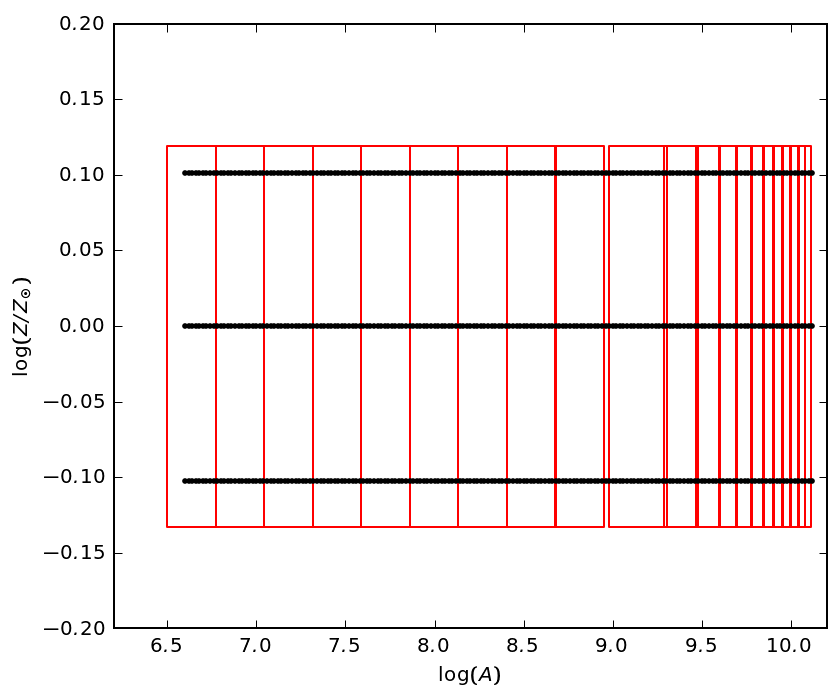

In [20]:
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 1, wspace=0.4, bottom=0.2, right=0.95)
ax = fig.add_subplot(gs[0])
pipeline.plot_lockfile(ax)
fig.show()

## Fitting the F475W-F814W RGB/AGB

To begin, we will attempt to fit the red giant branch in the F475W-F814W plane. In this fitting plane, shown below as a sum of simulated SSP Hess diagrams and observations, we omit any young main sequence stars. This allows us to concentrate on fitting just the evolved RGB and AGB stars.

/Users/jsick/phat_data


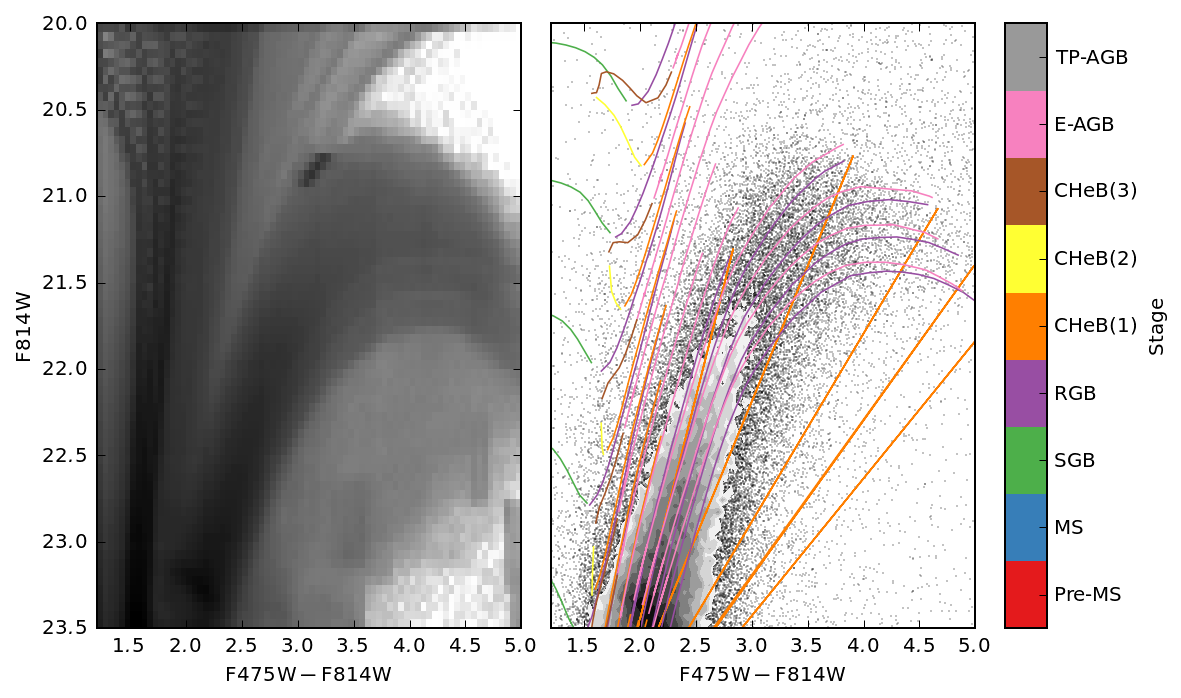

In [21]:
plane = pipeline.planes['f475w_f814w_rgb']
dataset._load_phat_data()

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(1, 3, wspace=0.1, bottom=0.2, right=0.95, width_ratios=(1, 1, 0.1))
ax_mod = fig.add_subplot(gs[0])
ax_obs = fig.add_subplot(gs[1])
ax_phases = fig.add_subplot(gs[2])
pipeline.plot_sim_hess(ax_mod, 'f475w_f814w_rgb')
contour_hess(ax_obs, dataset.get_phot(('F475W', 'F814W')), dataset.get_phot('F814W'),
             plane.xlim, plane.ylim)
plot_isochrone_phases(ax_obs, 'F475W', 'F814W', show_cb=True, cb_ax=ax_phases)
ax_obs.set_xlim(*plane.xlim)
ax_obs.set_ylim(*plane.ylim)
ax_obs.set_xlabel(plane.x_label)
for tl in ax_obs.yaxis.get_major_ticks():
    tl.set_visible(False)
fig.show()

**Above left:** sum of simulated Hess diagrams. **Above right:** observed Hess diagram that is being fit here.

Solar metallicity isochrones for a grid of ages are plotted with the observed Hess diagram. These isochrones are labelled by evolutionary phase. The main locus of stars is dominated by RGB and Early-AGB stars. The big and blue areas of this Hess plane contain sub-giant branch (SGB) and Core He-Burning stars. Overall, the solar-metallicity isochrones appear to coincide well with the observations, including the peak of the RGB/AGB sequence luminosity function.

In [22]:
pipeline.fit('rgb', ['f475w_f814w_rgb'], dataset)

Below we see the star formation history fit from this Hess plane. In the top row the star formation history is shown as a star formation rate, while in the bottom row the raw Hess diagram amplitudes—total number of stars born in an isochrone's epoch—are plotted. Note that these star formation rates are summed over the entire brick area.

Overall, the fit implies a relatively constant star formation in this brick.

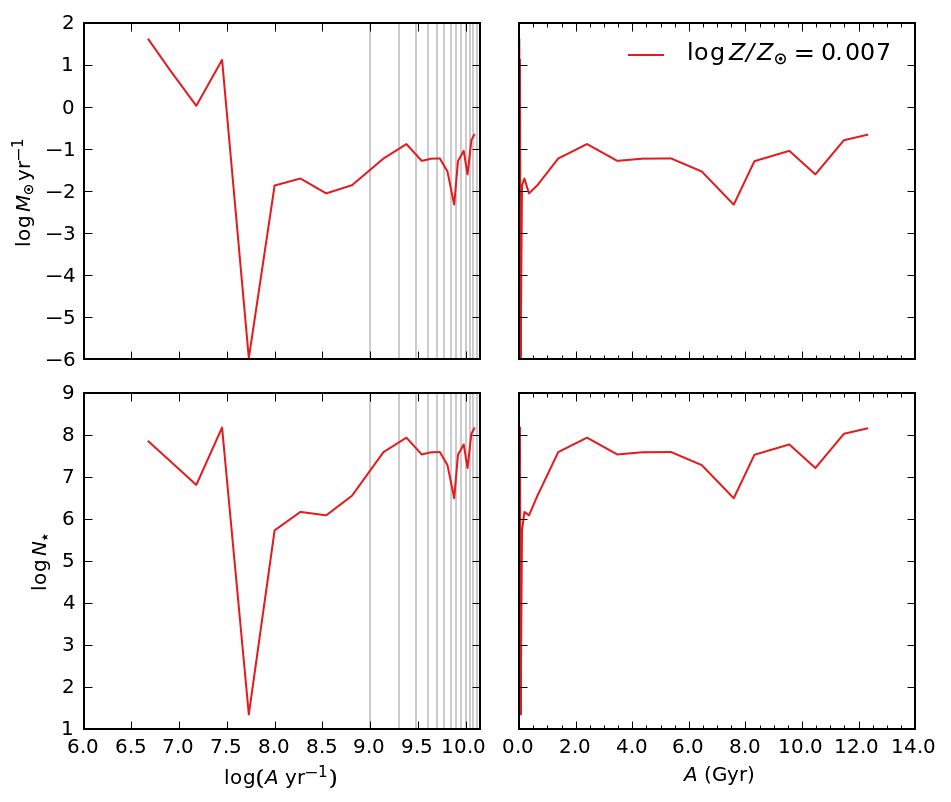

In [23]:
show_sfh_line(pipeline, 'rgb')

In the plots below we can easily visualize the quality of the fit. The observed (left most) and modelled (second to left) Hess diagrams for the fitted plane are shown as the log of the number of stars per Hess pixel. The $\chi^2$ visualization shows the fit is successful across most of the populated RGB/AGB sequence, except near the red clump ($23.5 > \mathrm{F814W} > 23$) and in the oldest RGB/AGB stars that occupy the extremely red tip of the luminosity function.

The right most plot shows where the model under-predicts (blue) or over-predicts (red) the stellar population on the Hess plane in units of stars per Hess pixel. Overall the simulated RGB/AGB is too narrow, suggesting a range of metallicities or extinctions are needed to broaden the population's colours. Most concerning is that the fit's disagreement worsens down the luminosity function.

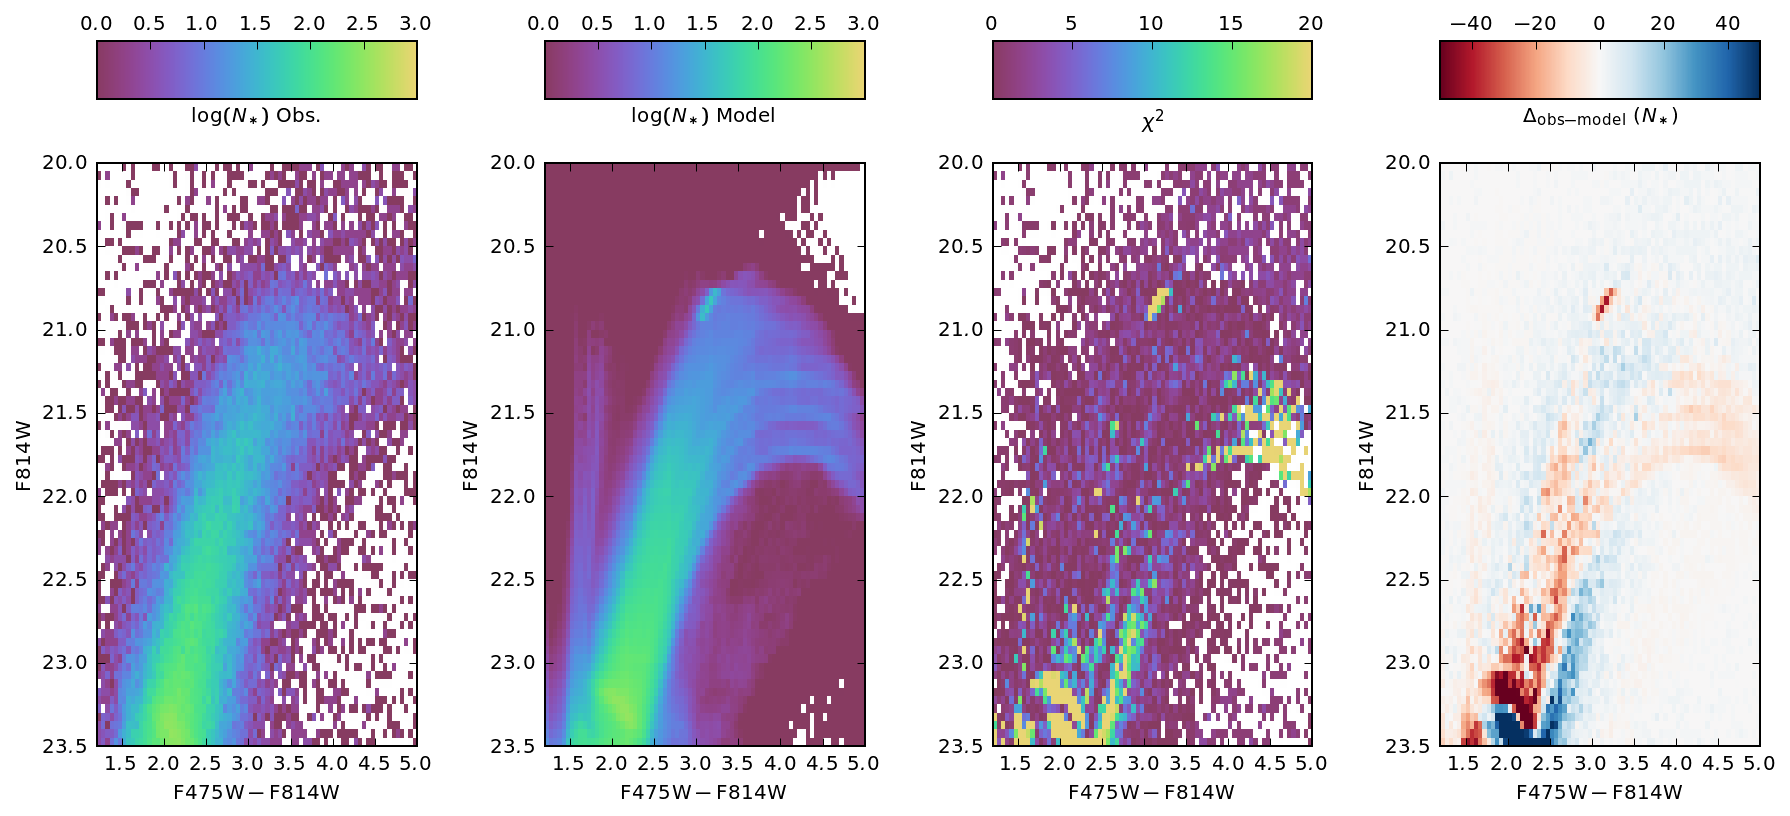

In [24]:
show_fit(pipeline, dataset, 'rgb', 'f475w_f814w_rgb')

### Visualization of the RGB fit extrapolated to other Hess planes

In the following sequence of plots, we'll examine how the fit to the optical RGB-only Hess diagram predicts other Hess planes. That is, we ask: how well does our fit to the upper RGB explain the entire stellar population?

#### Full F475W-F814W Plane

The model vastly over-predicts the main sequence population, as well as the red clump. Interestingly, the model does not explain the redness of the observations at the base of the RGB.

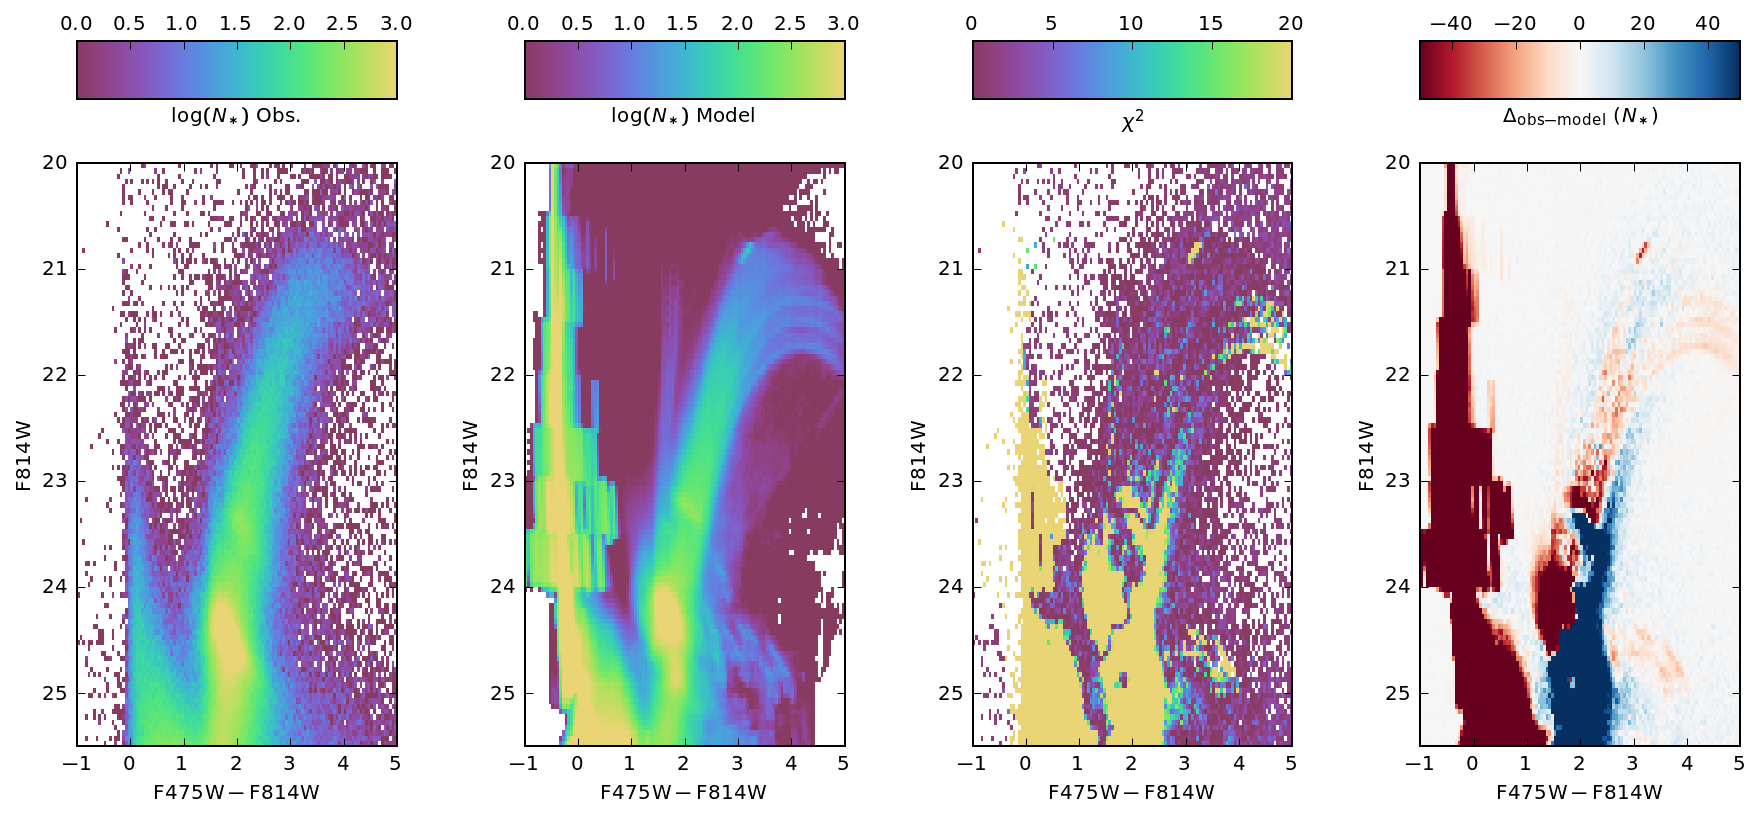

In [25]:
show_fit(pipeline, dataset, 'rgb', 'f475w_f814w')

#### F475W-F160W

In this panchromatic Hess diagram, our original fit predicts the F160W luminosity function very poorly. As well, the modelled optical-NIR colour of the main sequence is quite wrong.

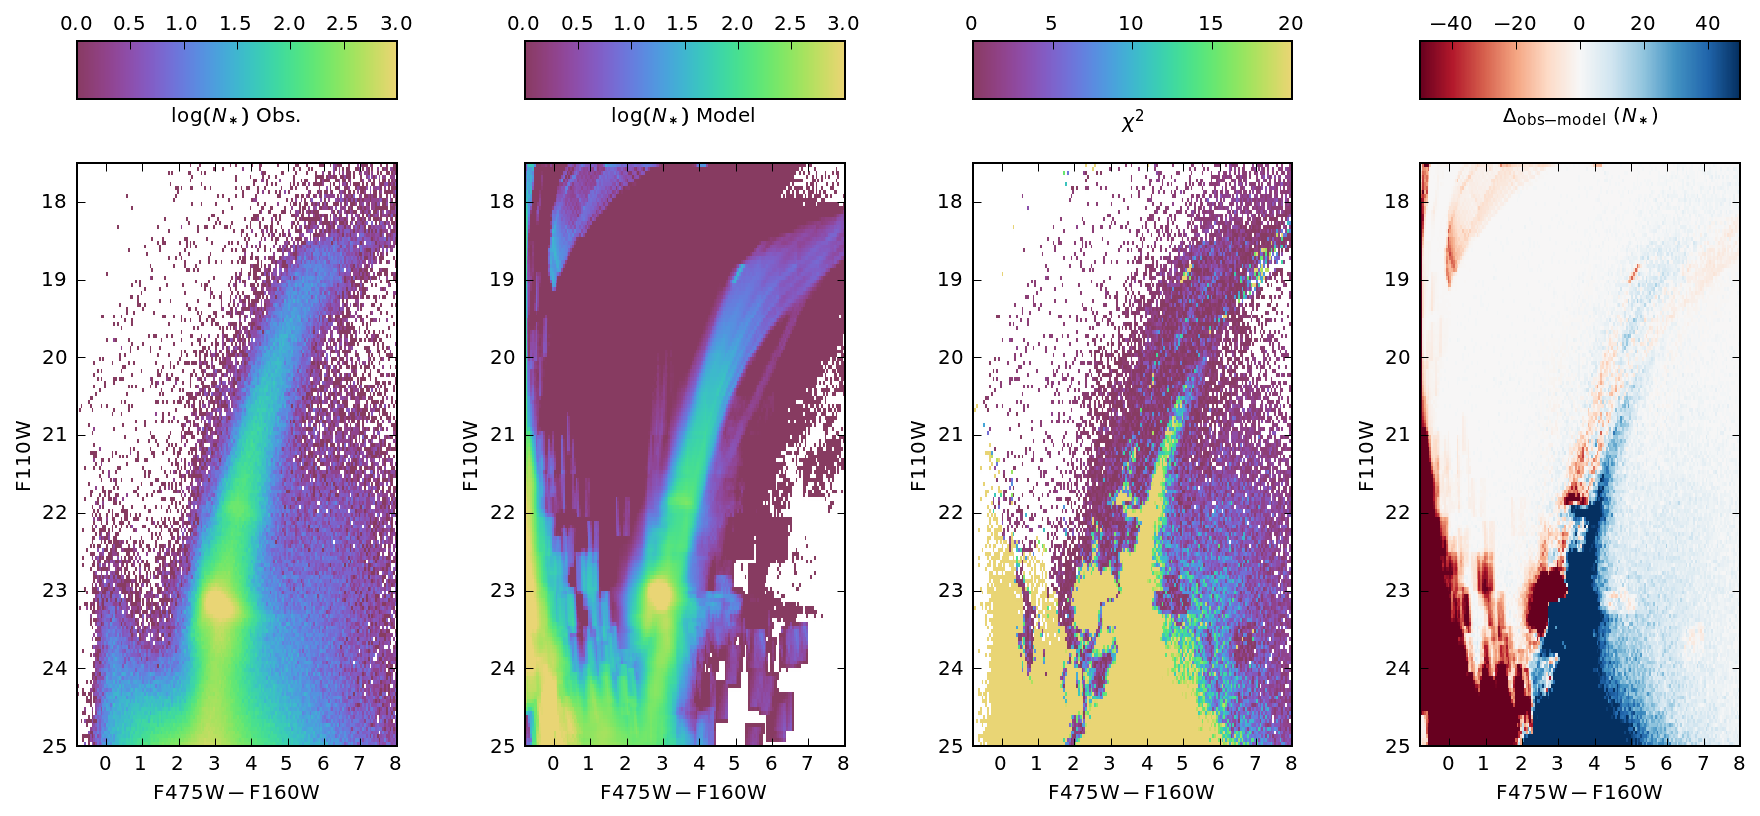

In [26]:
show_fit(pipeline, dataset, 'rgb', 'f475w_f160w')

#### F110W-F160W RGB/AGB

This Hess plane is an interesting comparison because it covers the same RGB/AGB population as the original fit, but now in a NIR colour baseline. Most concerning from this prediction is that the observed NIR RGB/AGB sequence is much redder than the model. There are two solutions:

1. higher metallicity isochrones are called for, or
2. dust extinction that reddens F110W-F160W by 0.2 mag is needed.

The first option is difficult to physically reconcile since this is a field at $R\sim 20$ kpc along the M31 disk. How can the stars be so enriched? The second option is plausible; I need to calculate what $A_V$ is implied by this reddening.

A final, troubling, possibility is that the near-IR WFC3 isochrones are incorrectly calibrated.

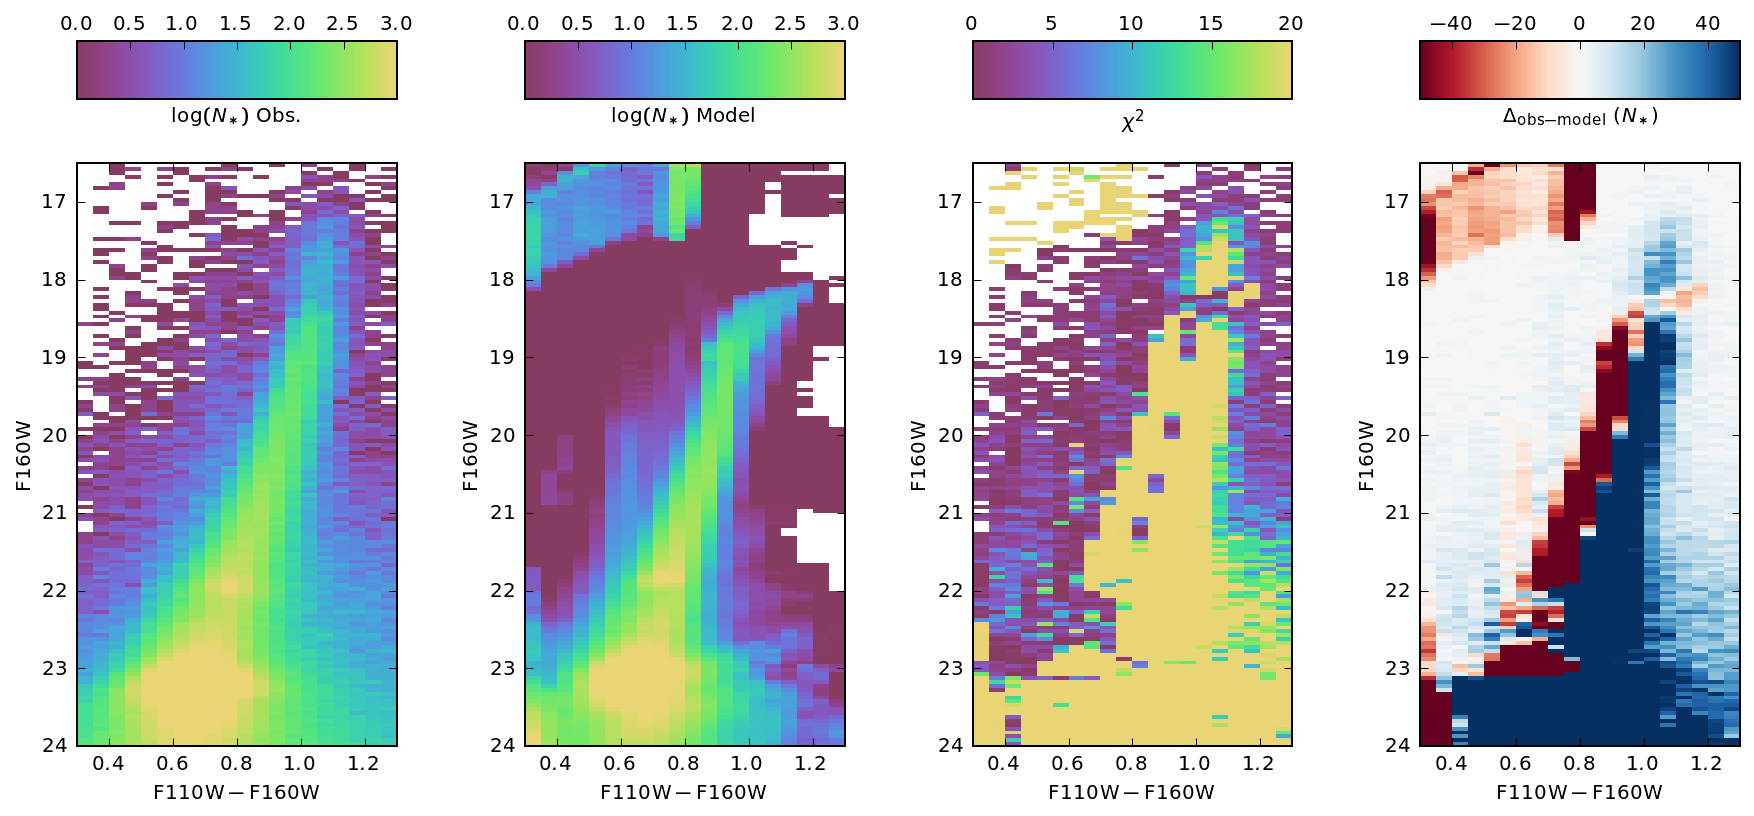

In [27]:
show_fit(pipeline, dataset, 'rgb', 'f110w_f160w')

## Fitting the whole F475W-F160W Hess Plane

Since the optical RGB proved to be an insufficient tool for predicting the entire stellar population, we can ask: can the entire F475W-F160W panchromatic Hess plane be fit, given the stated assumptions?

In [28]:
pipeline.fit('f475w_f160w', ['f475w_f160w'], dataset)

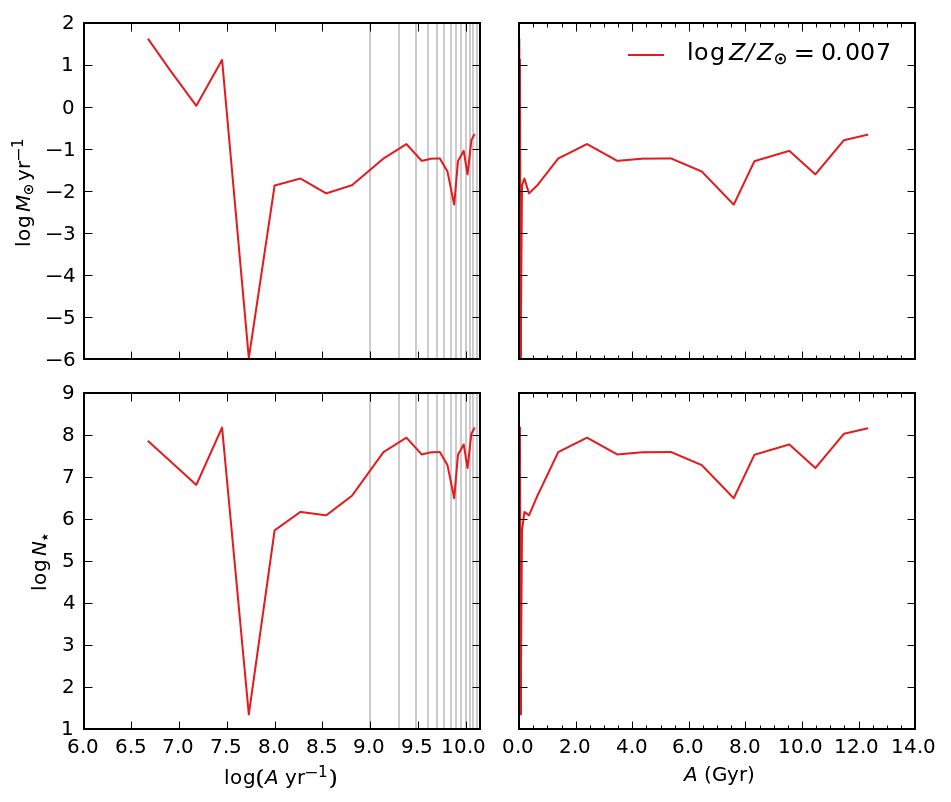

In [29]:
show_sfh_line(pipeline, 'f475w_f160w')

In this visualization of the fit, we see that the main sequence fit is much improved. The real trouble is in the RGB/AGB sequence. It appears that the modelled giant branch is too narrow. Again, dust and additional metallicities could solve this issue.

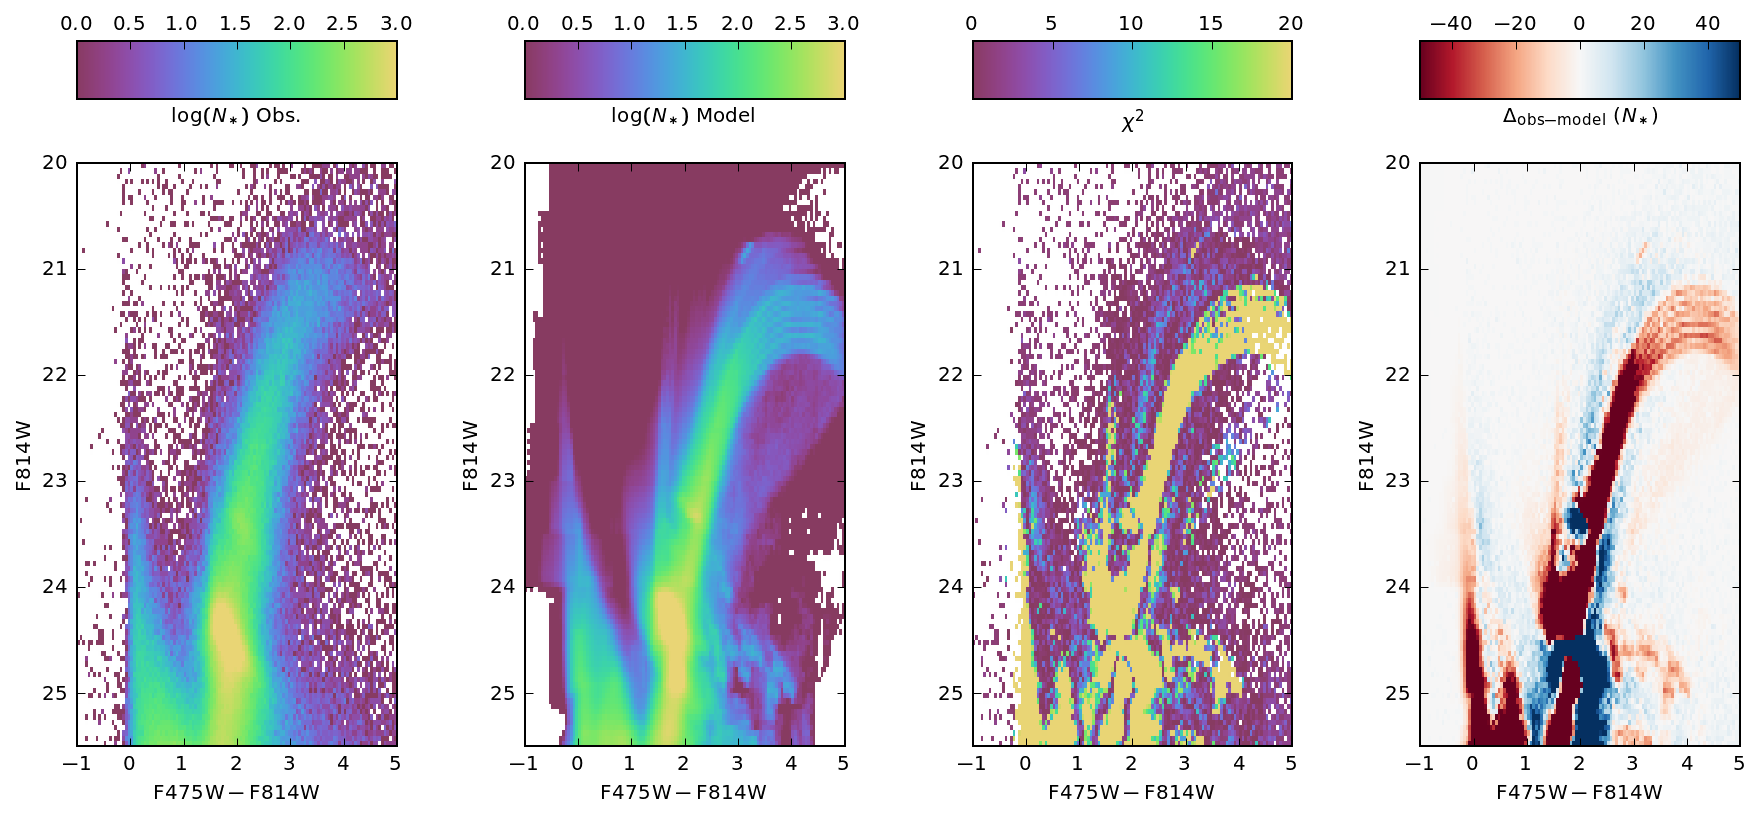

In [30]:
show_fit(pipeline, dataset, 'f475w_f160w', 'f475w_f814w')

## Fitting the F475W-F814W Main Sequence Only

Given the failure to fit the entire Hess plane, we now investigate just how well the optical main sequence can be fit with the models under current metallicity and dust assumptions. This essentially replicates the Lewis et al (2015), but without extinction.

In [31]:
pipeline.fit('ms', ['f475w_f814w_ms'], dataset)

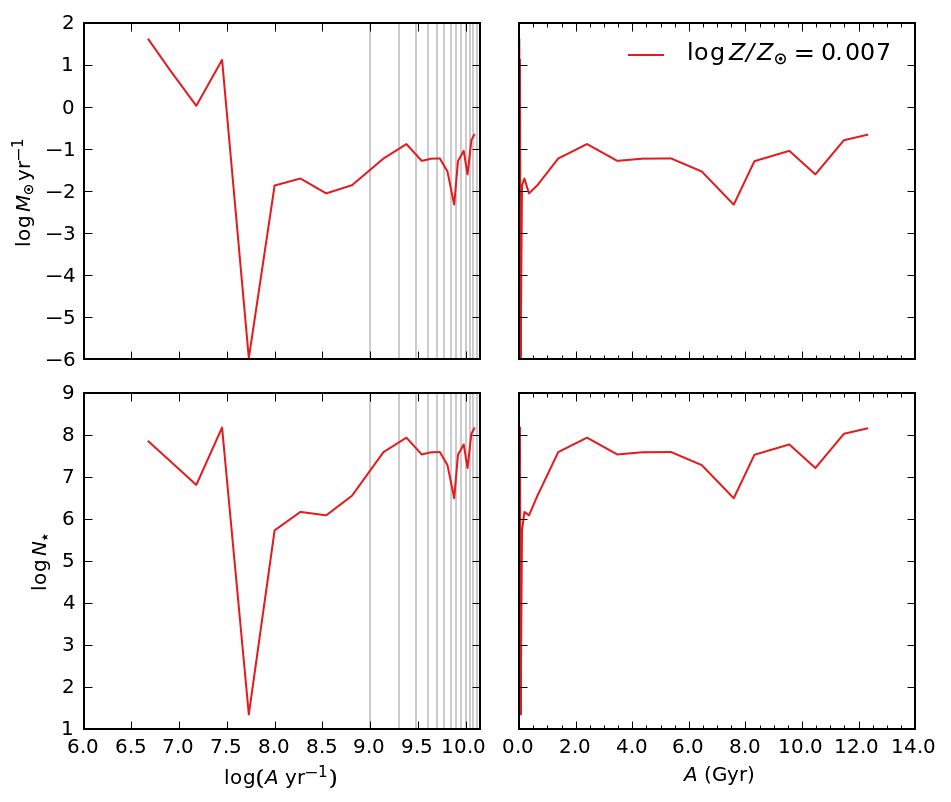

In [32]:
show_sfh_line(pipeline, 'ms')

Fitting just the main sequence population is quite successful, with only minor discrepancies in the $\chi^2$ plane. In comparison to the previous fit we also realize that the un-cropped F475W-F160W fit modelled the main sequence nearly as well as this MS-only fitting plane did.

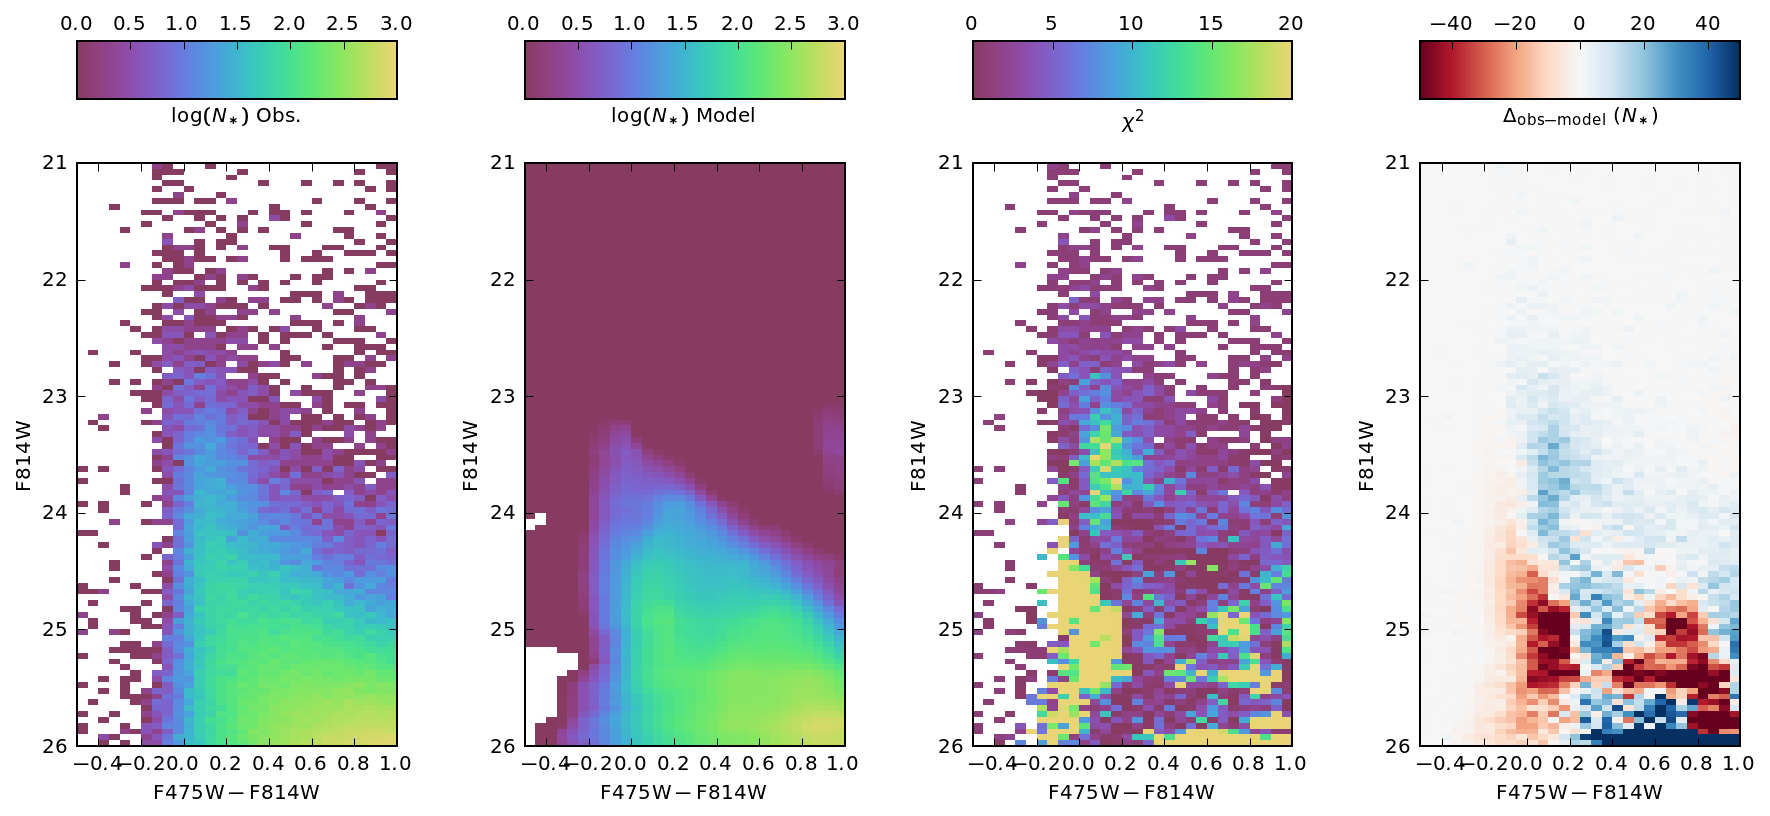

In [33]:
show_fit(pipeline, dataset, 'ms', 'f475w_f814w_ms')

### Extrapolation of the Main Sequence Fit to the F475W-F160W Hess Plane

While the Main Sequence fit does succeed in modelling the MS population, it severely under-predicts the RGB/AGB population.

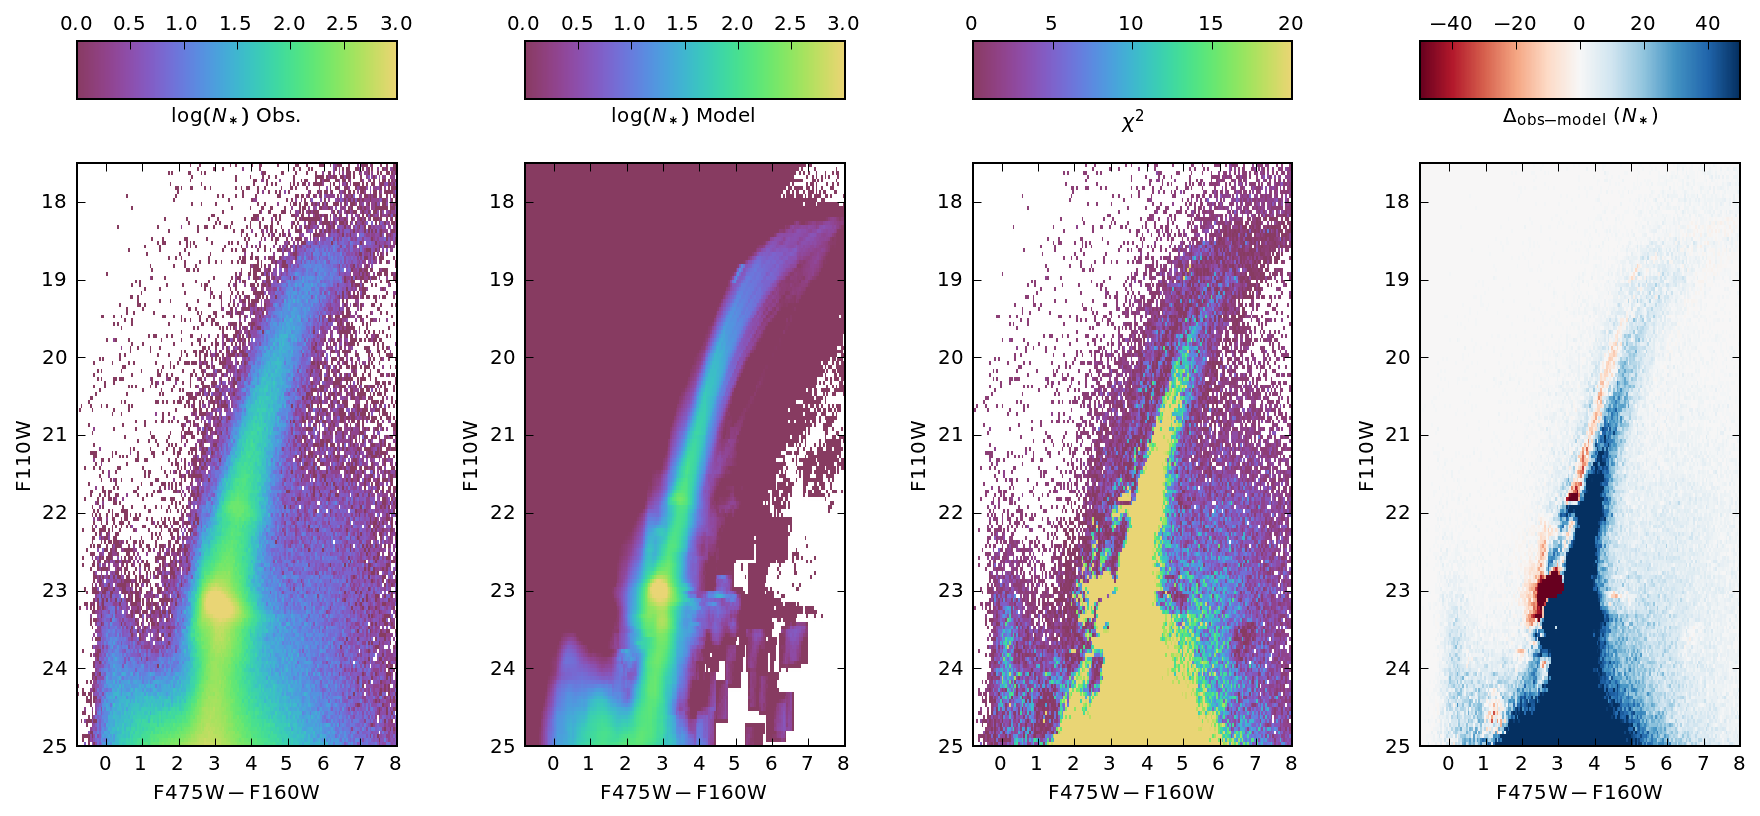

In [45]:
show_fit(pipeline, dataset, 'ms', 'f475w_f160w')

## Comparison of Fitted Star Formation Histories

In [40]:
tbl_ms = pipeline.fits['ms'].solution_table()
tbl_rgb = pipeline.fits['rgb'].solution_table()
tbl_oir = pipeline.fits['f475w_f160w'].solution_table()

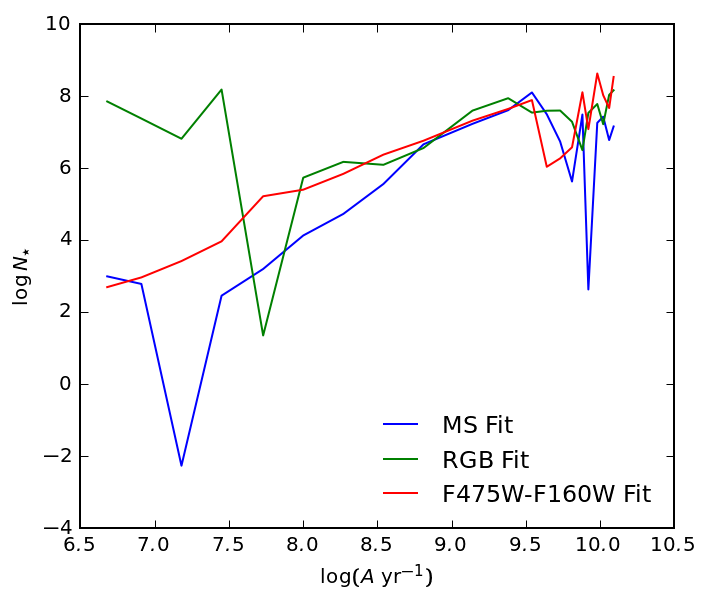

In [42]:
fig = plt.figure(figsize=(5, 5))
gs = GridSpec(1, 1, wspace=0.4, bottom=0.2, right=0.95)
ax = fig.add_subplot(gs[0])
ax.plot(tbl_ms['log(age)'], np.log10(tbl_ms['amp_nstars']), label="MS Fit")
ax.plot(tbl_rgb['log(age)'], np.log10(tbl_rgb['amp_nstars']), label="RGB Fit")
ax.plot(tbl_oir['log(age)'], np.log10(tbl_oir['amp_nstars']), label="F475W-F160W Fit")
ax.legend(loc='lower right', fontsize=12, frameon=False)
ax.set_xlabel(r'$\log(A~\mathrm{yr}^{-1})$')
ax.set_ylabel(r'$\log N_\star$')
fig.show()

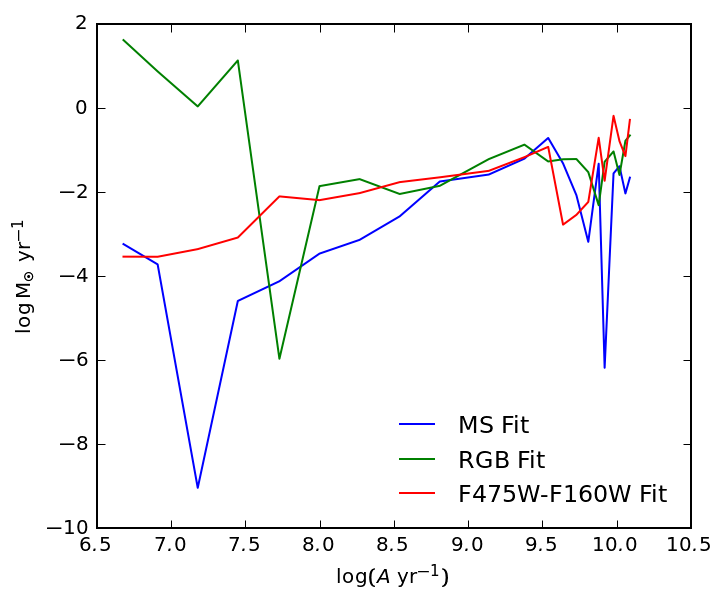

In [44]:
fig = plt.figure(figsize=(5, 5))
gs = GridSpec(1, 1, wspace=0.4, bottom=0.2, right=0.95)
ax = fig.add_subplot(gs[0])
ax.plot(tbl_ms['log(age)'], np.log10(tbl_ms['sfr']), label="MS Fit")
ax.plot(tbl_rgb['log(age)'], np.log10(tbl_rgb['sfr']), label="RGB Fit")
ax.plot(tbl_oir['log(age)'], np.log10(tbl_oir['sfr']), label="F475W-F160W Fit")
ax.legend(loc='lower right', fontsize=12, frameon=False)
ax.set_xlabel(r'$\log(A~\mathrm{yr}^{-1})$')
ax.set_ylabel(r'$\log \mathrm{M}_\odot~\mathrm{yr}^{-1}$')
fig.show()

Despite the differences in fit quality (measured by the $\chi^2$ Hess planes), all fits generally agree on the star formation rate 1 Gyr ago and older. Fits that include the main sequence stellar populations generally model lower recent star formation rates.